Size of dataset: 51281
Fragment vocabulary size: 74


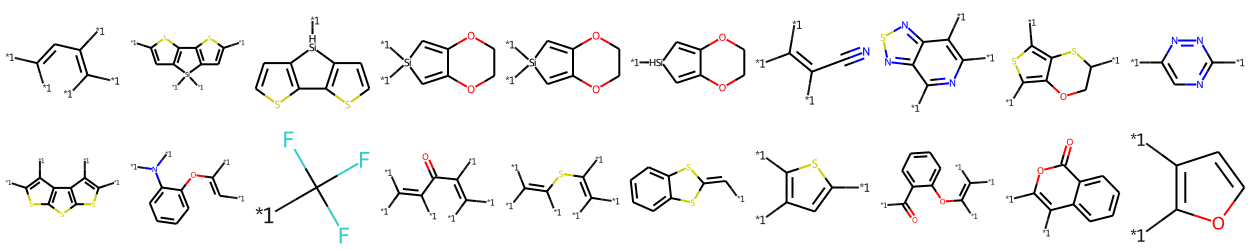

In [1]:
import selfies as sf
from group_selfies.group_mol_graph import Group
from group_selfies.group_grammar import GroupGrammar
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.drawMolsSameScale = False # DrawMolsZoomed
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
# RDLogger.EnableLog('rdApp.*')
from tdc import Oracle
sascore = Oracle('SA')

def num_aromatic_atoms(smi):
    return sum(1 for atom in m(smi).GetAtoms() if atom.GetIsAromatic())

import matplotlib.pyplot as plt
import numpy as np
from group_selfies.utils.fragment_utils import fragment_mols
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import re
import random
m = Chem.MolFromSmiles
def grid(mols, molsPerRow=10):
    return Draw.MolsToGridImage(mols, molsPerRow=molsPerRow, maxMols=1000, subImgSize=(125, 125), useSVG=True)

def split_selfies(selfies: str):

    left_idx = selfies.find("[")

    while 0 <= left_idx < len(selfies):
        right_idx = selfies.find("]", left_idx + 1)
        if right_idx == -1:
            raise ValueError("malformed SELFIES string, hanging '[' bracket")

        next_symbol = selfies[left_idx: right_idx + 1]
        yield next_symbol

        left_idx = right_idx + 1
        if selfies[left_idx: left_idx + 1] == ".":
            yield "."
            left_idx += 1

def shuffle(selfies):
    """
    Shuffle a SELFIES string.
    """
    return "".join(sorted(split_selfies(selfies), key=lambda x: random.random()))

new_constraints = sf.get_preset_constraints("default")
new_constraints['Si'] = 4
sf.set_semantic_constraints(new_constraints)

from group_selfies import get_preset_constraints, set_semantic_constraints
new_constraints = get_preset_constraints("default")
new_constraints['Si'] = 4
set_semantic_constraints(new_constraints)

# get some molecules from the ZINC dataset
nonfullerene = [x.strip() for x in open('../tests/test_sets/nonfullerene.csv')][1:]
print(f"Size of dataset: {len(nonfullerene)}")
# pick N random molecules from lines
#### if you try running this notebook you should reduce N to 1,000 or 10,000
N = min(100_000, len(nonfullerene))
####
smis = random.sample(nonfullerene, N)
selfis = [sf.encoder(smi) for smi in smis]

empty_grammar = GroupGrammar()

load_from_disk = True

if load_from_disk:
    grammar = GroupGrammar.from_file('nfa_test_grammar.txt') | GroupGrammar.essential_set() #load
else:
    # extracting a set of reasonable groups using fragmentation
    fragments = fragment_mols(smis, convert=True, method='default', target=50) # use custom fragmentation technique
    vocab_fragment = dict([(f'frag{idx}', Group(f'frag{idx}', frag)) for idx, frag in enumerate(fragments)])
    grammar = GroupGrammar(vocab_fragment)
    grammar.to_file('nfa_test_grammar.txt')

print('Fragment vocabulary size:', len(grammar.vocab))
display(grid([g.mol for g in grammar.vocab.values()][:20]))

100%|██████████| 51281/51281 [00:06<00:00, 8090.33it/s]


Length of SELFIES strings: 63.38 +/- 12.29 tokens
Total number of SELFIES tokens: 3250250


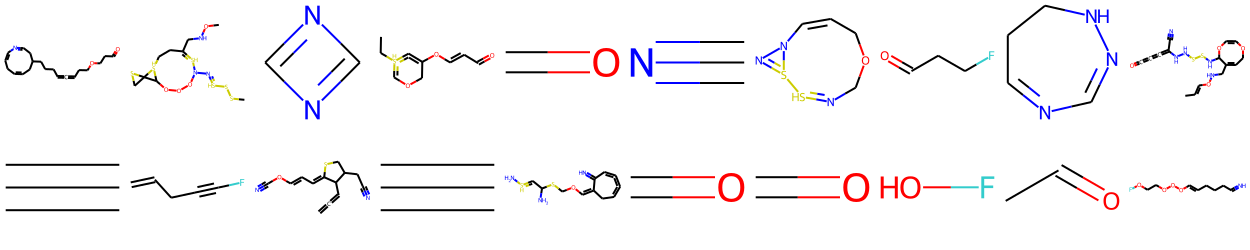

In [2]:
# split all selfies into tokens
split_selfis = [list(split_selfies(selfi)) for selfi in selfis]
# count the number of tokens in each selfi
selfi_lengths = [len(selfi) for selfi in split_selfis]

# combine all tokens from split_selfis into one list
selfi_alphabet = [token for selfi in split_selfis for token in selfi]

# generate random selfies strings from the alphabet
gen_selfi_smis = []
gen_selfis = []
for i in tqdm(range(N)):
    while True:
        gen_selfi = ''.join(random.sample(selfi_alphabet, random.choice(selfi_lengths)))
        gen_selfi_smi = sf.decoder(gen_selfi)
        if gen_selfi_smi != '':
            break
    gen_selfis.append(gen_selfi)
    gen_selfi_smis.append(gen_selfi_smi)

# decode into RDKit moles
gen_selfi_mols = [m(smi) for smi in gen_selfi_smis]

print(f"Length of SELFIES strings: {np.mean(selfi_lengths):.2f} +/- {np.std(selfi_lengths):.2f} tokens")
print(f"Total number of SELFIES tokens: {len(selfi_alphabet)}")

grid(gen_selfi_mols[:20])

Encoding... Done encoding


100%|██████████| 51281/51281 [01:11<00:00, 722.20it/s]


Length of Group SELFIES strings: 40.90 +/- 16.14
Total number of Group SELFIES tokens: 2097460


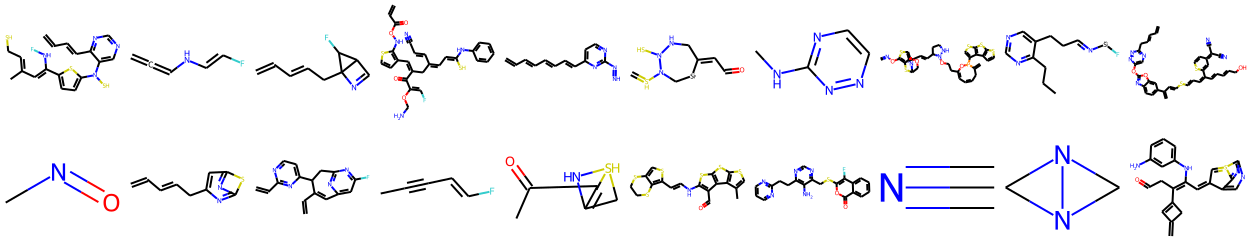

In [3]:
# encode all molecules into Group SELFIES
# grammar = GroupGrammar.from_file('zinc_test_grammar.txt') | GroupGrammar.essential_set()
def g_encoder(smi):
    # grammar = GroupGrammar.from_file('zinc_test_grammar.txt')
    encoded = grammar.full_encoder(m(smi))
    decoded = Chem.MolToSmiles(grammar.decoder(encoded))
    assert Chem.CanonSmiles(smi) == decoded, (smi, decoded, len(grammar.vocab))
    return encoded

print('Encoding... ', end='')
with Pool() as p:
    gselfis = p.map(g_encoder, smis)
print('Done encoding')

# # split all selfies into tokens
split_gselfis = [list(split_selfies(selfi)) for selfi in gselfis]

# # count the number of tokens in each selfi
gselfi_lengths = [len(selfi) for selfi in split_gselfis]

# # combine all tokens from split_selfis into one list
gselfi_alphabet = [token for selfi in split_gselfis for token in selfi]

gen_gselfis = []
gen_gselfi_smis = []
for i in tqdm(range(N)):
    while True:
        gen_gselfi = ''.join(random.sample(gselfi_alphabet, random.choice(gselfi_lengths)))
        gen_gselfi_mol = grammar.decoder(gen_gselfi)
        gen_gselfi_smi = Chem.MolToSmiles(gen_gselfi_mol)
        if gen_gselfi_smi != '':
            break
    gen_gselfis.append(gen_gselfi)
    gen_gselfi_smis.append(gen_gselfi_smi)

# decode into RDKit moles
gen_gselfi_mols = [m(smi) for smi in gen_gselfi_smis]

print(f"Length of Group SELFIES strings: {np.mean(gselfi_lengths):.2f} +/- {np.std(gselfi_lengths):.2f}")
print(f"Total number of Group SELFIES tokens: {len(gselfi_alphabet)}")

grid(gen_gselfi_mols[:20])

100%|██████████| 51281/51281 [01:04<00:00, 793.26it/s]


Length of Substring SELFIES strings: 68.05 +/- 30.85


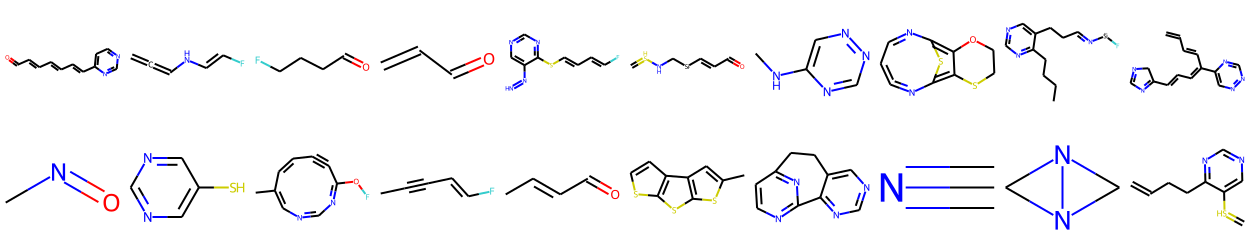

In [4]:
substring_dict = dict()
for key, val in grammar.vocab.items():

    gmol = Chem.RWMol(val.mol)
    remove = []
    for atom in val.mol.GetAtoms():
        if atom.GetSymbol() == '*':
            remove.append(atom.GetIdx())

    for i in reversed(remove):
        gmol.RemoveAtom(i)

    substring_dict[key] = empty_grammar.full_encoder(m(Chem.MolToSmiles(gmol)))

gen_subgselfis = []
subgselfi_lengths = []
for gen_gselfi in gen_gselfis:
    substring_gselfi = ''
    for tok in split_selfies(gen_gselfi):
        match = re.search(r"\[:(.*?)\d+(.*)\]", tok)
        if match is not None:
            substring_gselfi += substring_dict[match.group(2)]
        else:
            substring_gselfi += tok
    gen_subgselfis.append(substring_gselfi)
    subgselfi_lengths.append(len(list(split_selfies(substring_gselfi))))

gen_subgselfi_smis = [Chem.MolToSmiles(empty_grammar.decoder(selfi)) for selfi in tqdm(gen_subgselfis)]
gen_subgselfi_mols = [m(smi) for smi in gen_subgselfi_smis]

print(f"Length of Substring SELFIES strings: {np.mean(subgselfi_lengths):.2f} +/- {np.std(subgselfi_lengths):.2f}")

grid(gen_subgselfi_mols[:20])

100%|██████████| 51281/51281 [01:11<00:00, 717.39it/s]


Length of Group SELFIES strings with no groups: 67.10 +/- 12.99
Total number of Group SELFIES tokens with no groups: 3440797


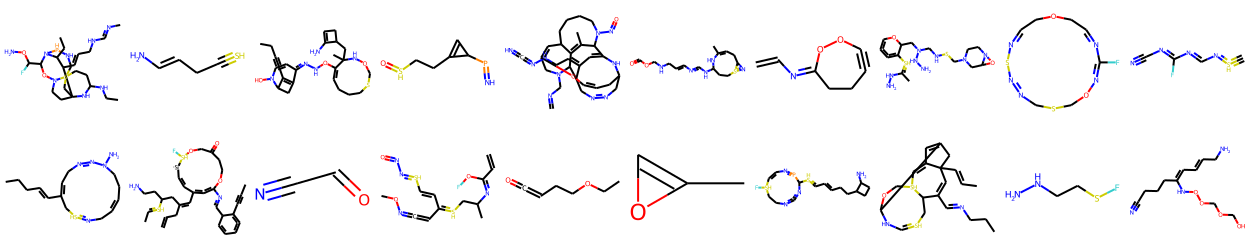

In [5]:
# group selfies with no groups

# encode all molecules into Group SELFIES
nogselfis = [empty_grammar.full_encoder(m(smi)) for smi in tqdm(smis)]

# split all selfies into tokens
split_nogselfis = [list(split_selfies(selfi)) for selfi in nogselfis]

# count the number of tokens in each selfi
nogselfi_lengths = [len(selfi) for selfi in split_nogselfis]

# combine all tokens from split_selfis into one list
nogselfi_alphabet = [token for selfi in split_nogselfis for token in selfi]

gen_nogselfis = []
gen_nogselfi_smis = []
for i in tqdm(range(N)):
    while True:
        gen_nogselfi = ''.join(random.sample(nogselfi_alphabet, random.choice(nogselfi_lengths)))
        gen_nogselfi_mol = grammar.decoder(gen_nogselfi)
        gen_nogselfi_smi = Chem.MolToSmiles(gen_nogselfi_mol)
        if gen_nogselfi_smi != '':
            break
    gen_nogselfis.append(gen_nogselfi)
    gen_nogselfi_smis.append(gen_nogselfi_smi)

# decode into RDKit moles
gen_nogselfi_mols = [m(smi) for smi in gen_nogselfi_smis]

print(f"Length of Group SELFIES strings with no groups: {np.mean(nogselfi_lengths):.2f} +/- {np.std(nogselfi_lengths):.2f}")
print(f"Total number of Group SELFIES tokens with no groups: {len(nogselfi_alphabet)}")

grid(gen_nogselfi_mols[:20])

In [6]:
with Pool() as p:
    sascores = p.map(sascore, smis)
    naromatics = p.map(num_aromatic_atoms, smis)
    selfi_sascores = p.map(sascore, gen_selfi_smis)
    selfi_naromatics = p.map(num_aromatic_atoms, gen_selfi_smis)
    gselfi_sascores = p.map(sascore, gen_gselfi_smis)
    gselfi_naromatics = p.map(num_aromatic_atoms, gen_gselfi_smis)
    subgselfi_sascores = p.map(sascore, gen_subgselfi_smis)
    subgselfi_naromatics = p.map(num_aromatic_atoms, gen_subgselfi_smis)
    nogselfi_sascores = p.map(sascore, gen_nogselfi_smis)
    nogselfi_naromatics = p.map(num_aromatic_atoms, gen_nogselfi_smis)

In [7]:
import pandas as pd

values = "NFA|Group SELFIES|SELFIES|Substring SELFIES|No-Group SELFIES".split('|')
cat_order = "NFA|Group SELFIES|SELFIES|Substring SELFIES|No-Group SELFIES".split('|')
df = pd.DataFrame({"NFA": sascores, "SELFIES": selfi_sascores, "Group SELFIES": gselfi_sascores, "Substring SELFIES": subgselfi_sascores, "No-Group SELFIES": nogselfi_sascores})
df = df.melt(value_vars=values, var_name="Type", value_name="SAScore").drop("Type", axis=1)

smiles_df = pd.DataFrame({"NFA": smis, "SELFIES": gen_selfi_smis, "Group SELFIES": gen_gselfi_smis, "Substring SELFIES": gen_subgselfi_smis, "No-Group SELFIES": gen_nogselfi_smis})
smiles_df = smiles_df.melt(value_vars=values, var_name="Type", value_name="SMILES")

naromatic_df = pd.DataFrame({"NFA": naromatics, "SELFIES": selfi_naromatics, "Group SELFIES": gselfi_naromatics, "Substring SELFIES": subgselfi_naromatics, "No-Group SELFIES": nogselfi_naromatics}).melt(value_vars=values, var_name="Type", value_name="NumAromaticAtoms").drop("Type", axis=1)
df = pd.concat([df, smiles_df, naromatic_df], axis=1)
df

,SAScore,Type,SMILES,NumAromaticAtoms
0,3.831036,NFA,CN1C(=O)C(=Cc2noc(-c3ncnc(-c4cc5cc6c(F)c(F)sc6...,23
1,2.724883,NFA,O=C(c1nccc(N2C(=O)c3ccccc3C2=O)n1)c1nccc(N2C(=...,24
2,3.697329,NFA,C[Si]1(C)c2ccsc2-c2sc(-c3nccc(-c4nocc4C(=O)O)n...,21
3,4.646517,NFA,N#CC(C#N)=C1C=C(c2cocc2C(=O)c2cccs2)OC(C2COc3n...,15
4,4.302440,NFA,CN1C(=O)C2=C(C=Cc3ccnc(C#Cc4sc(C#N)c(F)c4F)n3)...,17
...,...,...,...,...
256400,5.877521,No-Group SELFIES,C#CNSOOC=C(N=CC(CO)CC1=C(NC)CCO1)C(OCC(=C)CNCO...,0
256401,5.965953,No-Group SELFIES,C=CNC(=CCC1(CN(C)N=NC)CC(CC=NOC=N)C1O)NC,0
256402,5.624148,No-Group SELFIES,CCC1C(C)CC2=CC(C=C=CN)(C=CC3CC=CCC=CC(ONNCN1C)...,0
256403,3.548888,No-Group SELFIES,NC=O,0


In [8]:
cat_order

['NFA', 'Group SELFIES', 'SELFIES', 'Substring SELFIES', 'No-Group SELFIES']

In [9]:
from scipy.stats import wasserstein_distance
counts, bin_edges = np.histogram(df.SAScore, bins='auto')

each_counts = []
for i in cat_order:
    counts, _ = np.histogram(df[df.Type == i].SAScore, bins=bin_edges)
    each_counts.append(counts)

sascore_wassersteins = [wasserstein_distance(bin_edges[:-1], bin_edges[:-1], each_counts[0], each_counts[i]) for i in range(len(cat_order))]
sascore_wassersteins

[0.0,
 0.7520848072782949,
 1.4984163697671584,
 0.6550277936711892,
 1.746383955867263]

In [10]:
from scipy.stats import wasserstein_distance
counts, bin_edges = np.histogram(df.NumAromaticAtoms, bins='auto')
bin_edges = bin_edges[1:]

each_counts = []
for i in cat_order:
    counts, _ = np.histogram(df[df.Type == i].NumAromaticAtoms, bins=bin_edges)
    each_counts.append(counts)

naromatic_wassersteins = [wasserstein_distance(bin_edges[:-1], bin_edges[:-1], each_counts[0], each_counts[i]) for i in range(len(cat_order))]
naromatic_wassersteins

[0.0,
 14.315680530241849,
 18.66461569804243,
 15.20248260305597,
 18.699674746149245]

NFA: Percent of molecules with 0 aromatic atoms: 0.29%
Group SELFIES: Percent of molecules with 0 aromatic atoms: 48.98%
SELFIES: Percent of molecules with 0 aromatic atoms: 98.26%


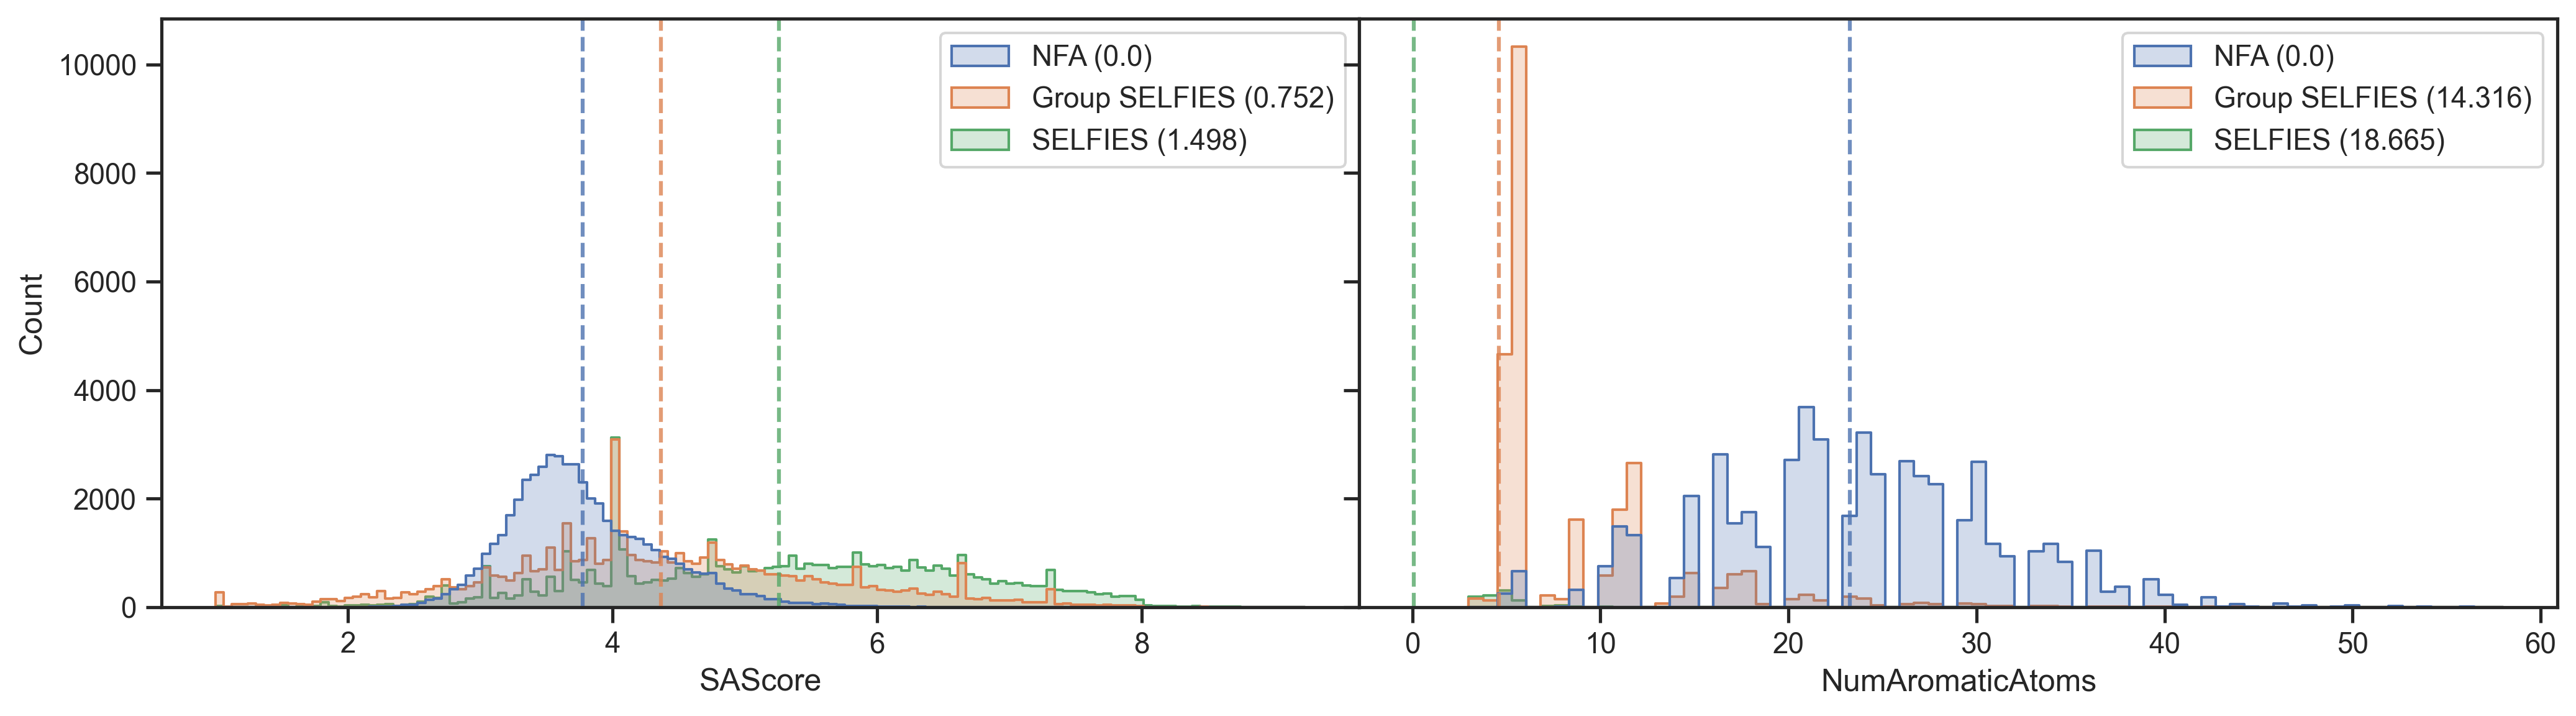

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# show means and show wasserstein distance

indices = [0, 1, 2]

my_sascore_wass = [sascore_wassersteins[i] for i in indices]
my_cat_order = [cat_order[i] for i in indices]
my_naromatic_wass = [naromatic_wassersteins[i] for i in indices]

sns.set(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True, dpi=300)
sns.histplot(data=df, x="SAScore", hue="Type", ax=ax1, hue_order=my_cat_order, element='step')
leg = ax1.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_sascore_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax1.axvline(df[df.Type == cat].SAScore.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

sns.histplot(data=df[df.NumAromaticAtoms > 0], x="NumAromaticAtoms", hue="Type", ax=ax2, hue_order=my_cat_order, element='step')
sns.move_legend(ax2, 'upper right')
leg = ax2.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_naromatic_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax2.axvline(df[df.Type == cat].NumAromaticAtoms.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.subplots_adjust(wspace=0)

for i, cat in enumerate(my_cat_order):
    print(f'{cat}: Percent of molecules with 0 aromatic atoms: {len(df[ (df.NumAromaticAtoms == 0) & (df.Type == cat)]) / len(df[df.Type == cat])*100:.2f}%')

plt.savefig('figures/nfa_gselfi_selfi.png')

NFA: Percent of molecules with 0 aromatic atoms: 0.29%
Group SELFIES: Percent of molecules with 0 aromatic atoms: 48.98%
Substring SELFIES: Percent of molecules with 0 aromatic atoms: 54.80%


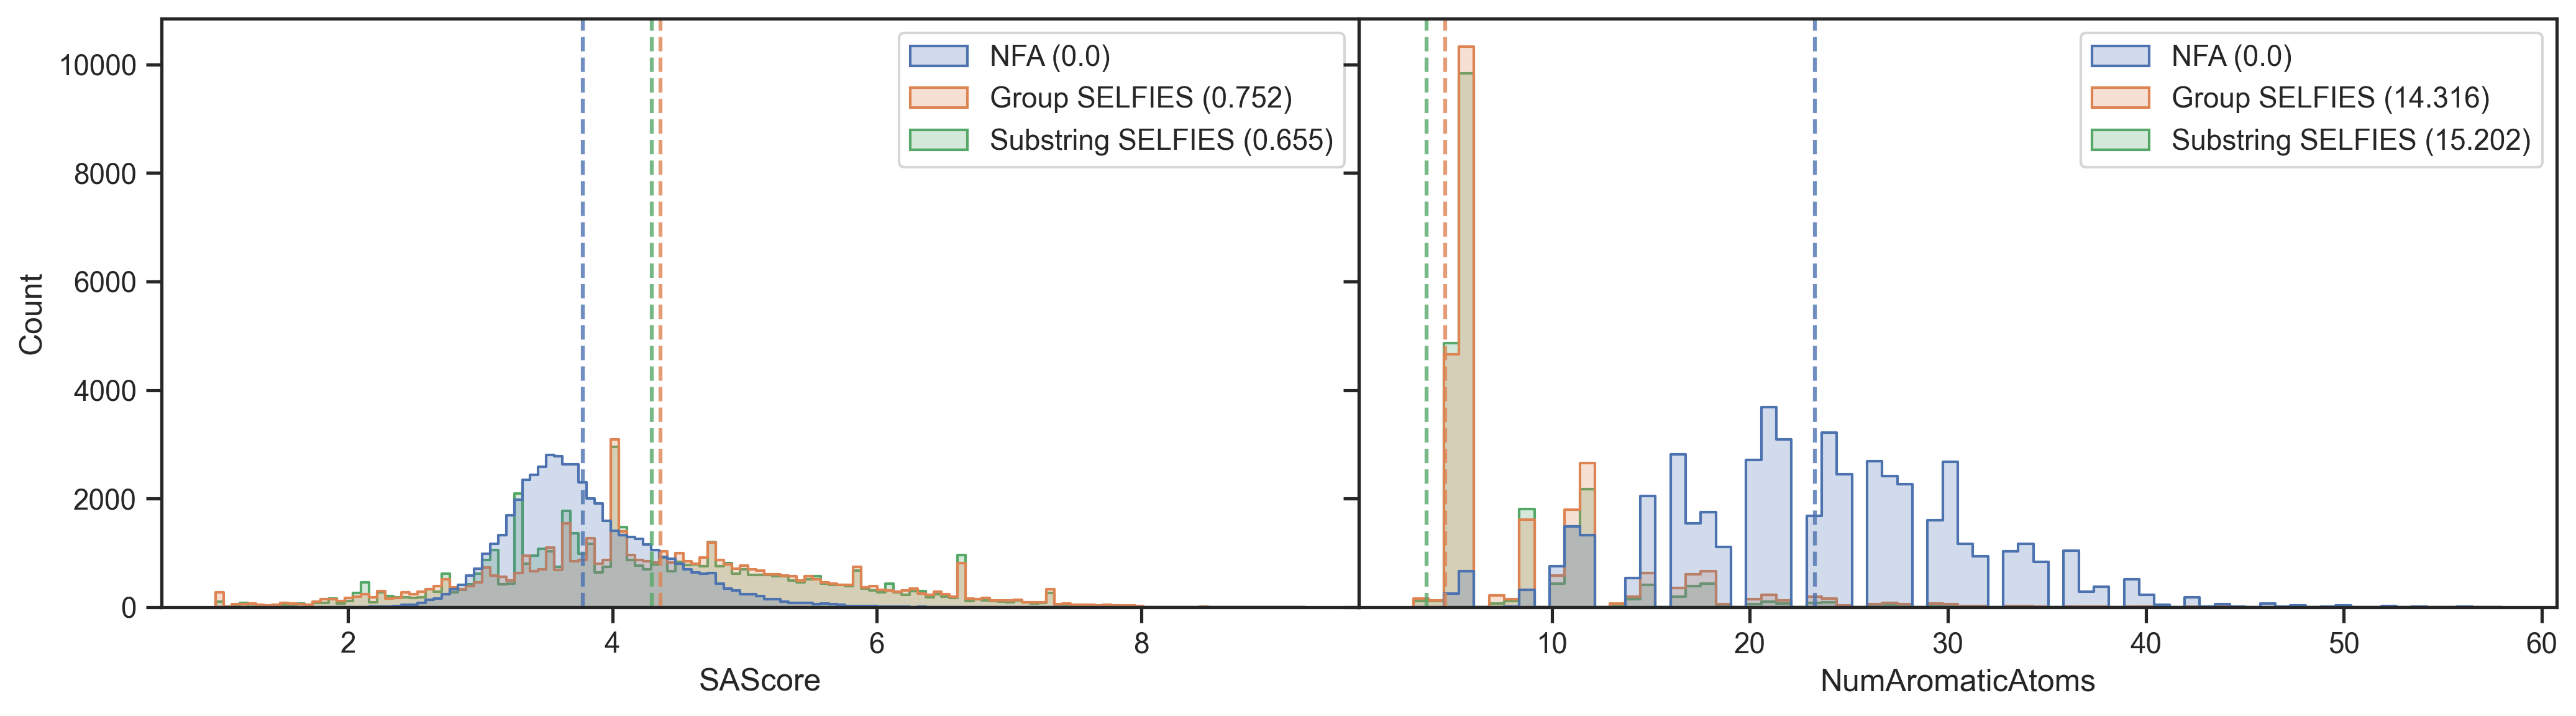

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# show means and show wasserstein distance

indices = [0, 1, 3]

my_sascore_wass = [sascore_wassersteins[i] for i in indices]
my_cat_order = [cat_order[i] for i in indices]
my_naromatic_wass = [naromatic_wassersteins[i] for i in indices]

sns.set(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True, dpi=300)
sns.histplot(data=df, x="SAScore", hue="Type", ax=ax1, hue_order=my_cat_order, element='step')
leg = ax1.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_sascore_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax1.axvline(df[df.Type == cat].SAScore.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

sns.histplot(data=df[df.NumAromaticAtoms > 0], x="NumAromaticAtoms", hue="Type", ax=ax2, hue_order=my_cat_order, element='step')
sns.move_legend(ax2, 'upper right')
leg = ax2.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_naromatic_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax2.axvline(df[df.Type == cat].NumAromaticAtoms.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.subplots_adjust(wspace=0)

for i, cat in enumerate(my_cat_order):
    print(f'{cat}: Percent of molecules with 0 aromatic atoms: {len(df[ (df.NumAromaticAtoms == 0) & (df.Type == cat)]) / len(df[df.Type == cat])*100:.2f}%')

plt.savefig('figures/nfa_gselfi_subselfi.png')

NFA: Percent of molecules with 0 aromatic atoms: 0.29%
SELFIES: Percent of molecules with 0 aromatic atoms: 98.26%
No-Group SELFIES: Percent of molecules with 0 aromatic atoms: 98.14%


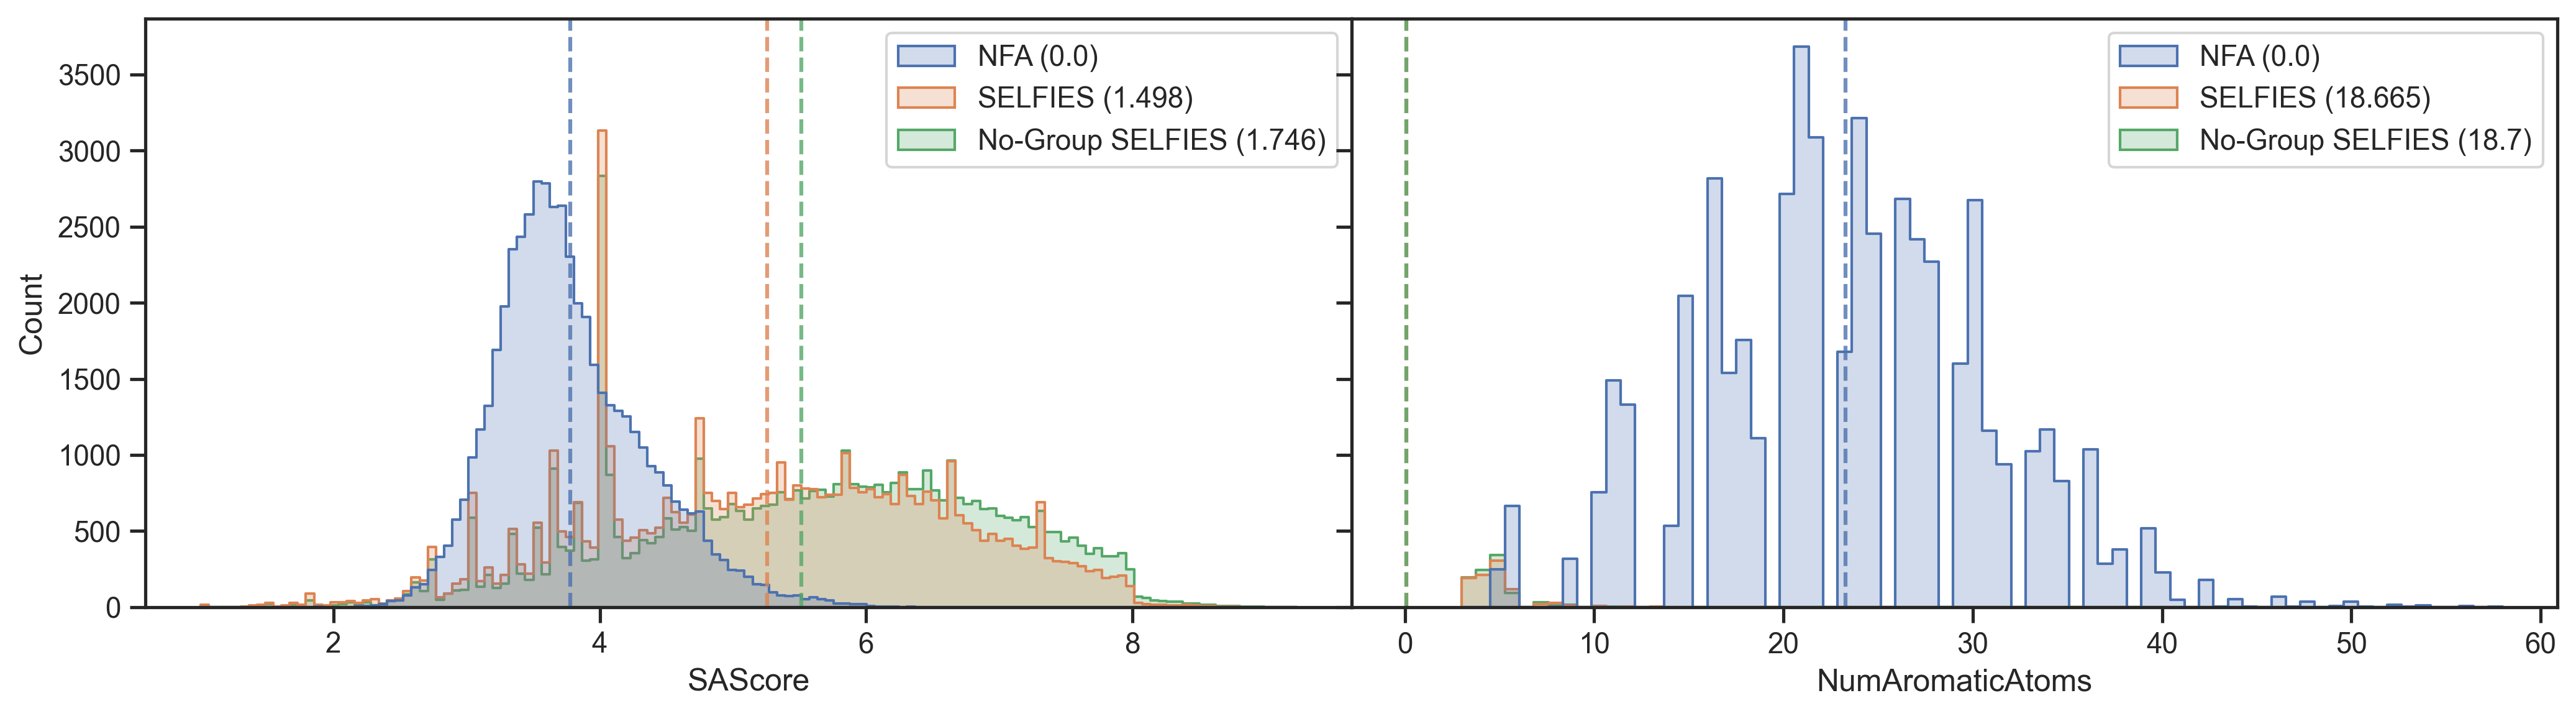

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# show means and show wasserstein distance

indices = [0, 2, 4]

my_sascore_wass = [sascore_wassersteins[i] for i in indices]
my_cat_order = [cat_order[i] for i in indices]
my_naromatic_wass = [naromatic_wassersteins[i] for i in indices]

sns.set(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True, dpi=300)
sns.histplot(data=df, x="SAScore", hue="Type", ax=ax1, hue_order=my_cat_order, element='step')
leg = ax1.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_sascore_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax1.axvline(df[df.Type == cat].SAScore.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

sns.histplot(data=df[df.NumAromaticAtoms > 0], x="NumAromaticAtoms", hue="Type", ax=ax2, hue_order=my_cat_order, element='step')
sns.move_legend(ax2, 'upper right')
leg = ax2.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_naromatic_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax2.axvline(df[df.Type == cat].NumAromaticAtoms.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.subplots_adjust(wspace=0)

for i, cat in enumerate(my_cat_order):
    print(f'{cat}: Percent of molecules with 0 aromatic atoms: {len(df[ (df.NumAromaticAtoms == 0) & (df.Type == cat)]) / len(df[df.Type == cat])*100:.2f}%')

plt.savefig('figures/nfa_selfi_nogselfi.png')

In [14]:
import plotly.express as px
import molplotly

fig = px.violin(df, y="SAScore", x="Type", box=True, points="all", hover_data=df.columns, category_orders=cat_order)

app = molplotly.add_molecules(fig=fig,
                               df=df,)
app.run_server(mode='inline', port=8705)

In [15]:
import plotly.express as px
import molplotly

fig = px.violin(df, y="NumAromaticAtoms", x="Type", box=True, points="all", hover_data=df.columns, category_orders=cat_order)

app = molplotly.add_molecules(fig=fig,
                               df=df,)
app.run_server(mode='inline', port=8706)